# Chatbot Logs Parsing

This notebook takes generated `example-logs` of the same format coming out of the launched chatbot and parses them for use later. We do some general analysis of those logs like looking at the average session count and IP/User-Agent distribution.

In [1]:
import re
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
from datetime import datetime
from user_agents import parse
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

## Define helper functions

In [2]:
# Function to parse a single log entry
def parse_log_entry(line):
    log_pattern = r'(\d+\.\d+\.\d+\.\d+) - \[(.*?)\] "SOCKET.IO (.*?)" - "(.*?)" - Event\((.*?)\): (.*)'
    match = re.match(log_pattern, line)
    if match:
        return {
            'ip': match.group(1),
            'date': datetime.fromisoformat(match.group(2).replace('Z', '+00:00')),
            'event': match.group(3),
            'user_agent': match.group(4),
            'socket_id': match.group(5),
            'data': match.group(6)
        }
    return None

# Function to extract messages from a chat session
def extract_messages(session):
    messages = []
    for entry in session:
        if ('"[START]"' == entry['data'] or '"[END]"' == entry['data']):
            continue
        if (entry['event'] == 'chat:ask'):
            try:
                data_json = json.loads(entry['data'])
            except json.JSONDecodeError:
                continue
            if isinstance(data_json, list):
                messages.extend(msg['content'] for msg in data_json if msg['role'] == 'user')
            elif isinstance(data_json, dict) and data_json['role'] == 'user':
                messages.append(data_json['content'])
    return messages

# Function to analyse response times of the chatbot using the START and END logs
def analyse_response_times(sessions):
    # Analyse start and end times
    ip_timestamps = defaultdict(list)
    for ip, event in sessions:
        for entry in event:
            data = entry['data']
            if ('"[START]"' == data or '"[END]"' == data):
                timestamp = entry['date']
                ip_timestamps[ip].append((data, timestamp))
    
    durations = []
    for ip, timestamps in ip_timestamps.items():
        timestamps.sort(key=lambda x: x[1])  # Sort by timestamp
        start_time = None
        
        for event, timestamp in timestamps:
            if event == '"[START]"':
                start_time = timestamp
            elif event == '"[END]"' and start_time:
                duration = (timestamp - start_time).total_seconds()
                durations.append(duration)
                start_time = None
    return durations

## Parse logs & Initial analysis

In [3]:
# Read and parse the log file
log_file_path = './example-logs.log'
parsed_logs = []
chat_sessions = defaultdict(list)

with open(log_file_path, 'r') as file:
    for line in file:
        parsed_entry = parse_log_entry(line)
        if parsed_entry:
            parsed_logs.append(parsed_entry)
            chat_sessions[parsed_entry['ip']].append(parsed_entry)

In [4]:
# Analysing general statistics
ip_counts = Counter(log['ip'] for log in parsed_logs)
df_dates = pd.DataFrame([log['date'] for log in parsed_logs], columns=['timestamp'])
df_dates['count'] = 1
request_times_frequency = df_dates.set_index('timestamp').resample('S').sum().fillna(0)

# Extracting chat messages
session_messages = {session_id: extract_messages(session) for session_id, session in chat_sessions.items()}

# Analysing session statistics
average_requests_per_ip = np.mean(list(ip_counts.values()))
average_time_between_requests = df_dates['timestamp'].diff().mean()
session_request_counts = [len(session) for session in chat_sessions.values()]
average_request_count = sum(session_request_counts) / len(session_request_counts)
questions_per_ip_counts = [len(messages) for messages in session_messages.values()]
average_question_count = sum(questions_per_ip_counts) / len(questions_per_ip_counts)
response_times = analyse_response_times(chat_sessions.items())
average_response_time = sum(response_times) / len(response_times)

# Display the results
print(f"Total amount of individual IPs: {len(ip_counts)}")
print(f"Average number of Requests per Session: {average_request_count:.2f}")
print(f"Average number of requests per IP: {average_requests_per_ip:.2f}")
print(f"Average number of questions per IP: {average_question_count:.2f}")
print(f"Average time between requests (s): {average_time_between_requests.total_seconds():.2f} (a bit false here as auto-generated)")
print(f"Average chat response time (s): {average_response_time:.2f} (a bit false here as auto-generated)")

Total amount of individual IPs: 100
Average number of Requests per Session: 11.61
Average number of requests per IP: 11.61
Average number of questions per IP: 2.75
Average time between requests (s): -0.04 (a bit false here as auto-generated)
Average chat response time (s): 13.78 (a bit false here as auto-generated)


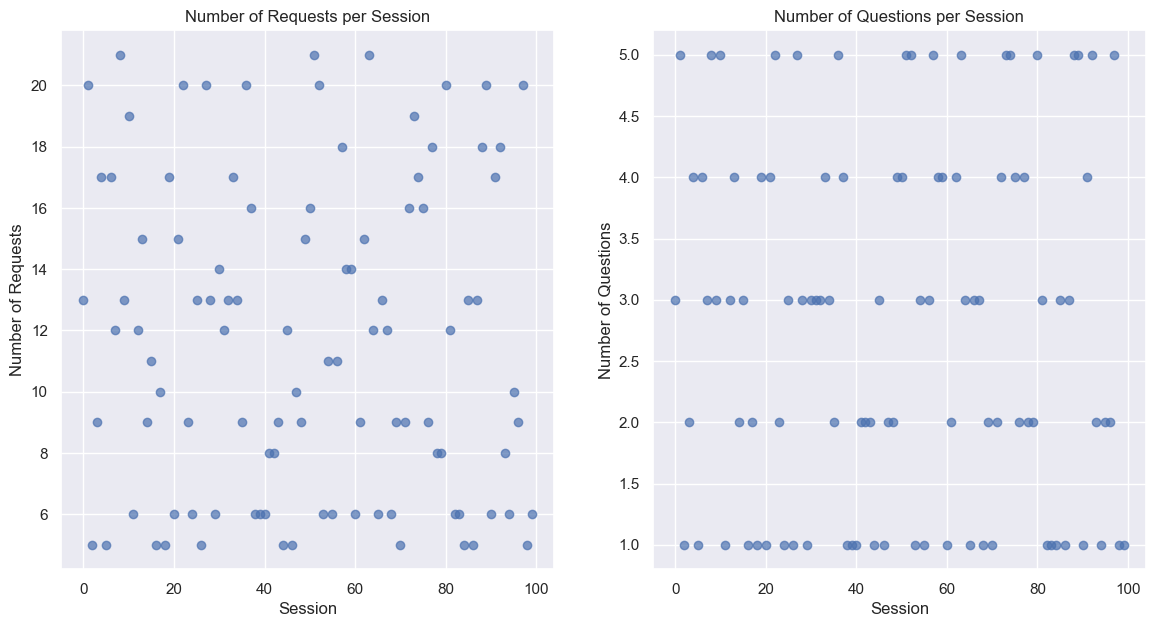

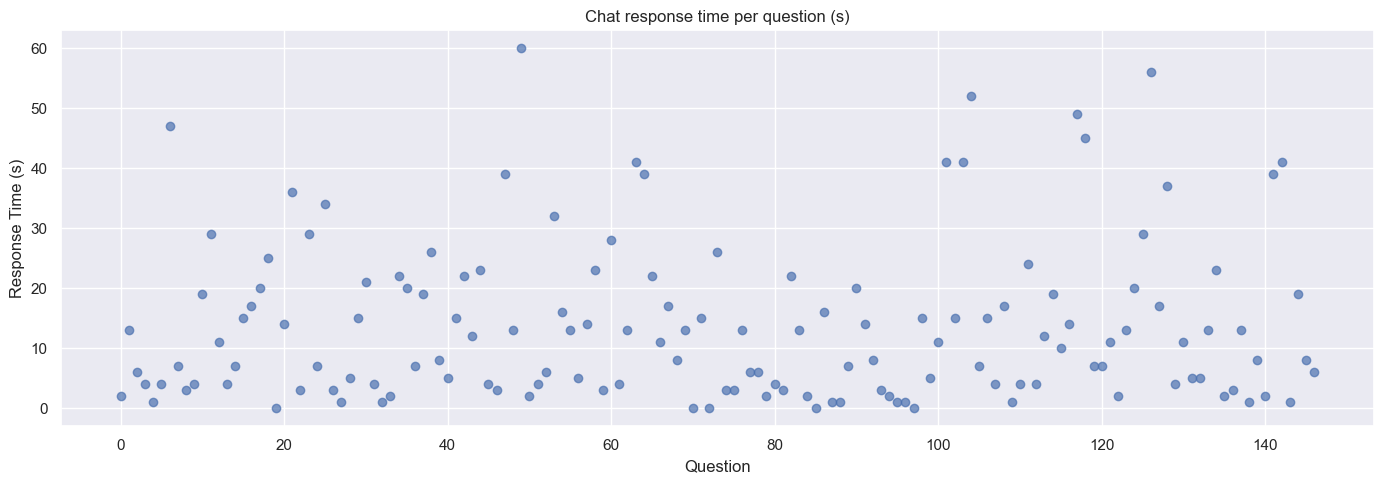

In [5]:
# Plotting scatter graphs
sns.set_theme()
plt.figure(figsize=(14, 7))

# Scatter graph for number of requests per session
plt.subplot(1, 2, 1)
plt.scatter(range(len(session_request_counts)), session_request_counts, alpha=0.7)
plt.title('Number of Requests per Session')
plt.xlabel('Session')
plt.ylabel('Number of Requests')
plt.grid(True)

# Scatter graph for questions per ip
plt.subplot(1, 2, 2)
plt.scatter(range(len(questions_per_ip_counts)), questions_per_ip_counts, alpha=0.7)
plt.title('Number of Questions per Session')
plt.xlabel('Session')
plt.ylabel('Number of Questions')
plt.grid(True)

plt.figure(figsize=(14,5))
plt.scatter(range(len(response_times)), response_times, alpha=0.7)
plt.xlabel('Question')
plt.ylabel('Response Time (s)')
plt.title('Chat response time per question (s)')

plt.tight_layout()

## Location & Device Analysis

In [6]:
# Assuming we have a list of IPs called 'unique_ips'
unique_ips = list({log['ip'] for log in parsed_logs})  # Extract unique IPs

# Function to get geolocation data
def get_geolocation(ip_list):
    url = "http://ip-api.com/batch"
    response = requests.post(url, json=ip_list)
    return response.json()

# Fetch geolocation data
geolocations = get_geolocation(unique_ips)

# Extract latitudes and longitudes
latitudes = [loc['lat'] for loc in geolocations if loc['status'] != 'fail']
longitudes = [loc['lon'] for loc in geolocations if loc['status'] != 'fail']

Text(0.5, 1.0, 'Geographic visualisation of user locations')

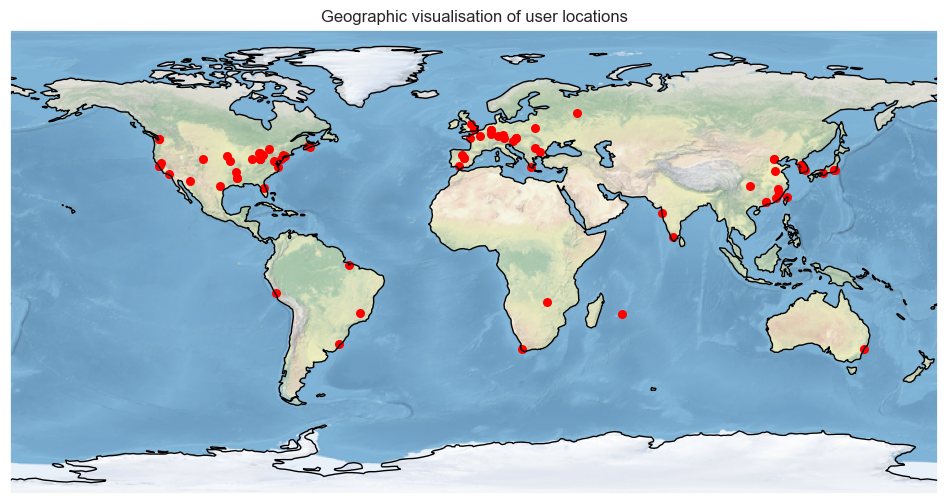

In [7]:
# Plotting
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()  # Add a background image
ax.coastlines()  # Draw coastlines
ax.scatter(longitudes, latitudes, color='red', marker='o', s=30, transform=ccrs.Geodetic())
fig.tight_layout()
plt.title("Geographic visualisation of user locations")

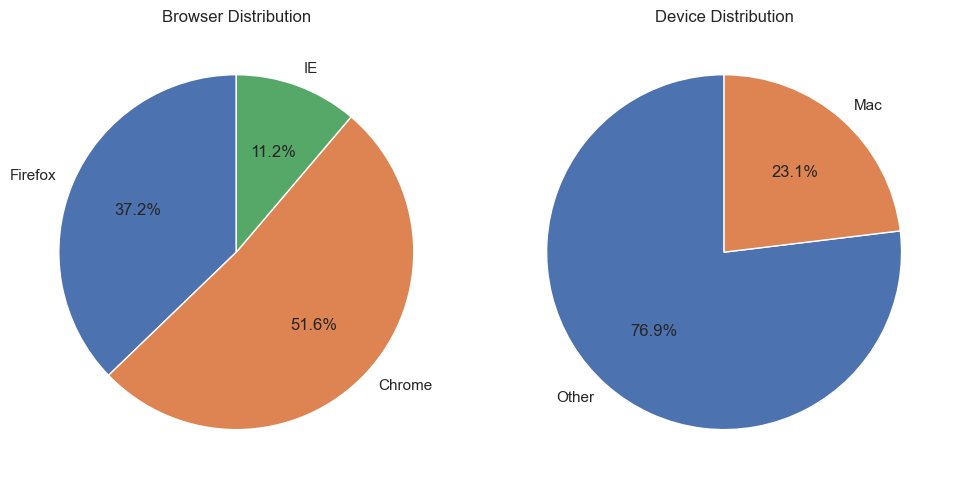

In [8]:
# Extract user agents
user_agent_strings = [log['user_agent'] for log in parsed_logs]

# Parse the user agent strings to get browser and device information
browsers = []
devices = []

for ua_string in user_agent_strings:
    user_agent = parse(ua_string)
    browsers.append(user_agent.browser.family)
    devices.append(user_agent.device.family)

# Count the occurrences of each browser and device
browser_counts = Counter(browsers)
device_counts = Counter(devices)

# Function to plot a pie chart
def plot_pie_chart(data, title, idx):
    labels = data.keys()
    sizes = data.values()

    ax = plt.subplot(1, 2, idx)
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.tight_layout()

# Plot pie charts
plt.figure(figsize=(10, 5))
plot_pie_chart(browser_counts, 'Browser Distribution', 1)
plot_pie_chart(device_counts, 'Device Distribution', 2)

### Save questions for further follow-up "sentiment" analysis

In [9]:
questions = [message for session in chat_sessions.values() for message in extract_messages(session)]
with open('./output_questions.json', 'w') as json_file:
    json.dump(questions, json_file, ensure_ascii=False)